In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(context="notebook", palette="Spectral", style = 'darkgrid' ,font_scale = 1.5, color_codes=True)
import os
from scipy import stats
from sklearn.feature_selection import SelectKBest, chi2
import datetime
from datetime import timedelta
import math

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler 

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix, recall_score, precision_score

from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC

from imblearn.under_sampling import RandomUnderSampler

# Pré processamento

In [9]:
df = pd.read_csv("./weather.csv")
date = df['Date']    
df = df.drop(['Sunshine','Evaporation','Cloud3pm','Cloud9am','Location','RISK_MM'],axis=1) #remove id column
df = df.dropna()

sin = []
cos = []
for i, date in enumerate(df['Date']):
    d = date
    year, month, day = map(int, d.split('-'))
    d = datetime.date(year, month, day)
    day_number = d.timetuple().tm_yday
    sin.append(np.sin(math.pi*2*(day_number - 1)/364)) 
    cos.append(np.cos(math.pi*2*(day_number - 1)/364)) 
df['Date_cos'] = cos
df['Date_sin'] = sin    

wind_directions = {
    'N': 90.0, 
    'NNE': (90 + 45) / 2,
    'NE': 45.0,
    'ENE': (45) / 2,
    'E': 0.0,
    'ESE': (0 - 45) / 2,
    'SE': -45.0,
    'SSE': (-90 - 45) / 2,
    'S': -90.0,
    'SSW': (-90 - 135) / 2,
    'SW': -135.0,
    'WSW': (180 - 135) / 2,
    'W': 180.0,
    'WNW': (180 + 135) / 2,
    'NW': 135.0,
    'NNW': (135 + 90) / 2
}

df['RainTomorrow'].replace({'Yes': 1, 'No': 0}, inplace = True)
df['RainToday'].replace({'Yes': 1, 'No': 0}, inplace = True)

def log(x):
        return np.log(x+0.1)

df['Rainfall'] = df['Rainfall'].apply(log) 

for column in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
    df[column].replace(wind_directions, inplace = True)
    df[column + '_cos'] = df[column].apply(np.cos) 
    df[column + '_sin'] = df[column].apply(np.sin)
    df.drop([column], axis=1, inplace=True)
   

df_autocorr = df.copy()

df = df.drop(['Date'],axis=1) #remove unused date column
df.head()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,...,RainToday,RainTomorrow,Date_cos,Date_sin,WindGustDir_cos,WindGustDir_sin,WindDir9am_cos,WindDir9am_sin,WindDir3pm_cos,WindDir3pm_sin
0,13.4,22.9,-0.356675,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,...,0,0,0.877303,-0.479937,-0.598460,-0.801153,-0.598460,-0.801153,0.912939,0.408096
1,7.4,25.1,-2.302585,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,...,0,0,0.885456,-0.464723,0.912939,0.408096,0.826837,-0.562441,-0.873305,-0.487175
2,12.9,25.7,-2.302585,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,...,0,0,0.893346,-0.449370,-0.873305,-0.487175,-0.598460,-0.801153,-0.873305,-0.487175
3,9.2,28.0,-2.302585,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,...,0,0,0.900969,-0.433884,0.525322,0.850904,0.525322,-0.850904,1.000000,0.000000
4,17.5,32.3,0.095310,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,...,0,0,0.908324,-0.418268,-0.598460,-0.801153,-0.873305,-0.487175,-0.996088,0.088369


## Gráficos de autocorrelação

Os dois registros anteriores das vairáveis que apresentarem maior autocorrelação serão usados como variáveis de entrada do modelo

In [10]:
df_autocorr.index = pd.Index(df_autocorr['Date'].values.squeeze())
df_autocorr = df_autocorr.drop(['Date'], axis=1)

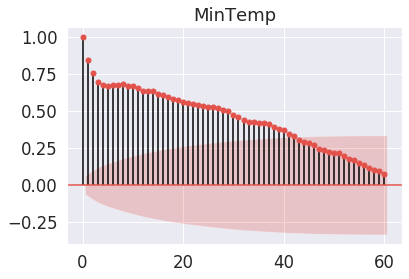

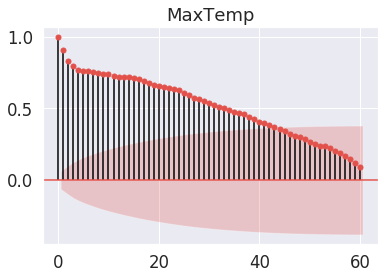

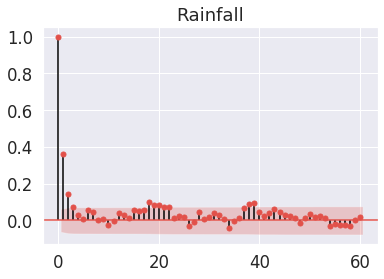

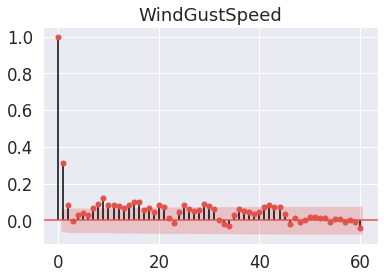

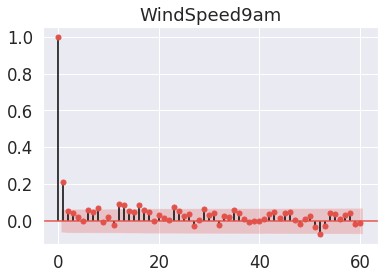

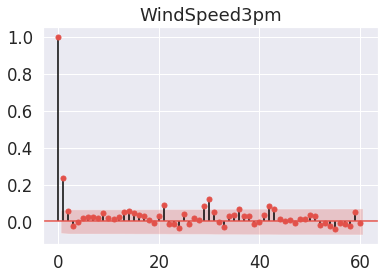

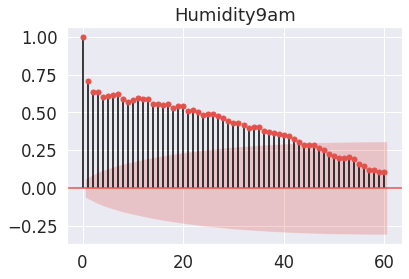

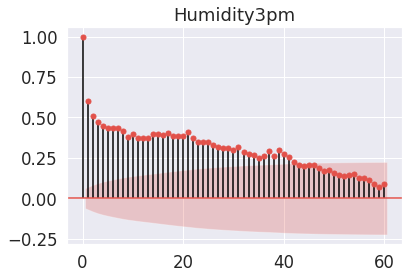

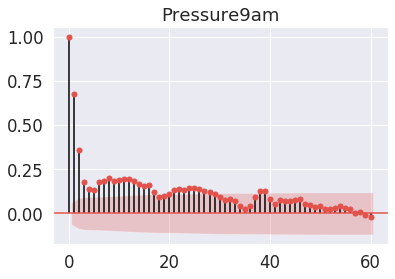

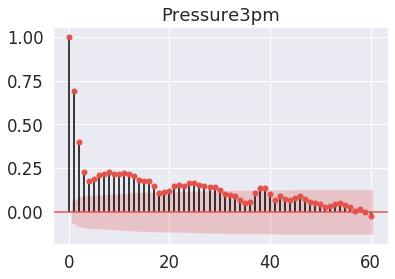

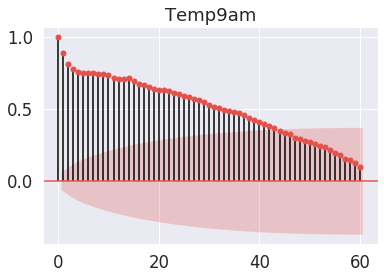

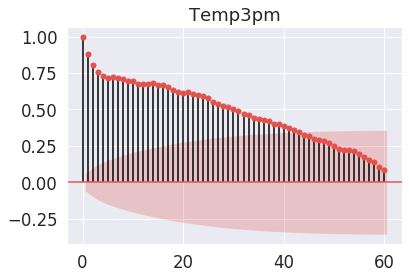

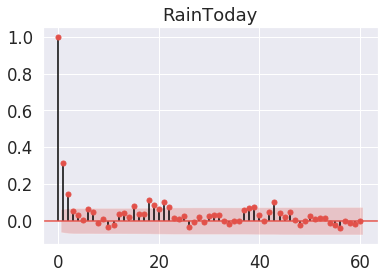

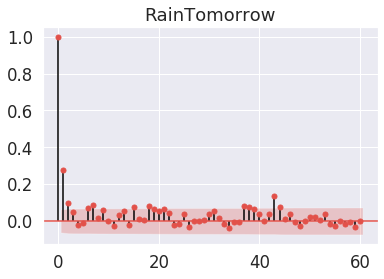

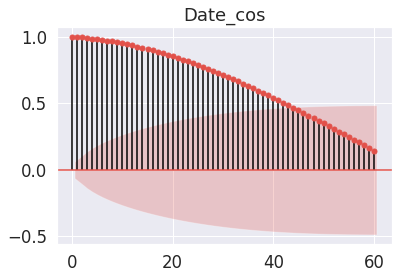

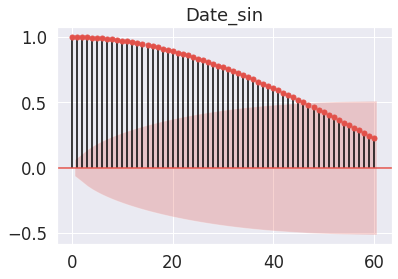

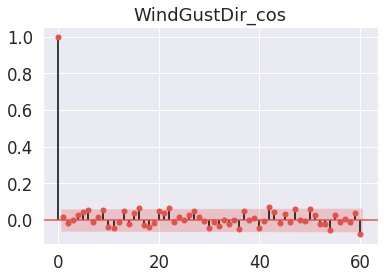

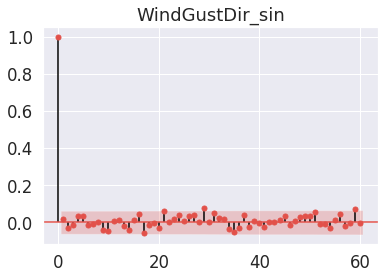

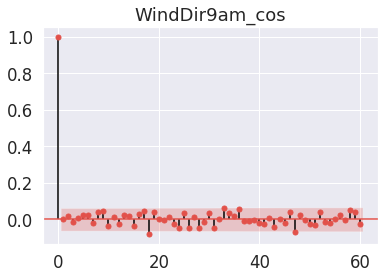

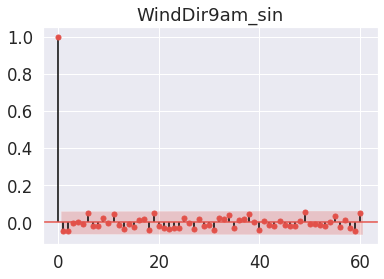

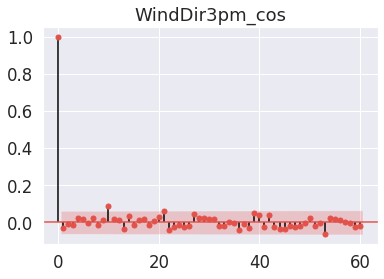

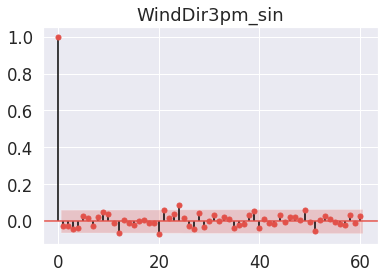

In [4]:
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm

for column in df_autocorr:
    sm.graphics.tsa.plot_acf(df_autocorr.drop(df_autocorr.columns.difference([column]), 1)[:1000].values.squeeze(), lags=60)
    plt.title(column)
    plt.show()

In [11]:
for col in df:
    if col in ["Humidity3pm","Humidity9am","MinTemp","MaxTemp"]:
        df[col+'-1'] = df[col].shift(periods=1, axis=0)
        df[col+'-2'] = df[col].shift(periods=2, axis=0)

df = df.iloc[2:]
df = df.reset_index(drop=True)
df.head()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,...,WindDir3pm_cos,WindDir3pm_sin,MinTemp-1,MinTemp-2,MaxTemp-1,MaxTemp-2,Humidity9am-1,Humidity9am-2,Humidity3pm-1,Humidity3pm-2
0,12.9,25.7,-2.302585,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,...,-0.873305,-0.487175,7.4,13.4,25.1,22.9,44.0,71.0,25.0,22.0
1,9.2,28.0,-2.302585,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,...,1.000000,0.000000,12.9,7.4,25.7,25.1,38.0,44.0,30.0,25.0
2,17.5,32.3,0.095310,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,...,-0.996088,0.088369,9.2,12.9,28.0,25.7,45.0,38.0,16.0,30.0
3,14.6,29.7,-1.203973,56.0,19.0,24.0,55.0,23.0,1009.2,1005.4,...,-0.598460,-0.801153,17.5,9.2,32.3,28.0,82.0,45.0,33.0,16.0
4,14.3,25.0,-2.302585,50.0,20.0,24.0,49.0,19.0,1009.6,1008.2,...,-0.598460,-0.801153,14.6,17.5,29.7,32.3,55.0,82.0,23.0,33.0


## Remoção de outliers

In [12]:
#Get mean distances

import time
from tqdm import tqdm
from sklearn.metrics import pairwise_distances_chunked

X = df.drop(['RainToday', 'RainTomorrow'],axis=1)
mean = []
chunks = pairwise_distances_chunked(X)
for chunk in tqdm(chunks):
    mean.extend(chunk.mean(1))

96it [02:15,  1.42s/it]


### Gráfico de distâncias ordenadas

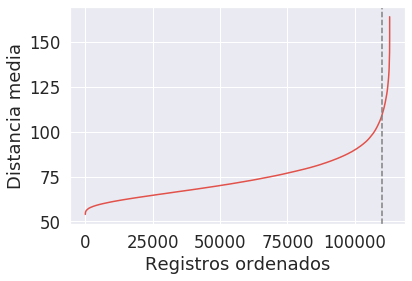

In [13]:
from ipywidgets import interact
import ipywidgets as widgets

sorted_mean = mean.copy()
sorted_mean.sort()

plt.plot(sorted_mean)
plt.xlabel('Registros ordenados')
plt.ylabel('Distancia media')
plt.axvline(x=110000, color="grey", linestyle="--")
plt.show()
    
    
# interact(plot, x=widgets.IntSlider(min=0, max=len(sorted_mean), step=1000, value=110000))

In [14]:
#Create dataframe without the outliers

df_distances = pd.DataFrame(mean, columns=["mean"])
df_distances = df_distances.sort_values(by=["mean"])
df_distances = df_distances.iloc[110000:]
df_distances.tail()

,mean
112029,151.242023
106475,151.770824
85848,153.097959
86533,161.331376
14762,164.165389


In [15]:
df = df.drop(df_distances.index.values.tolist())

## Análise de Componentes Principais
Removemos o número de componentes principais que nos permita manter 98% da variância total dos dados

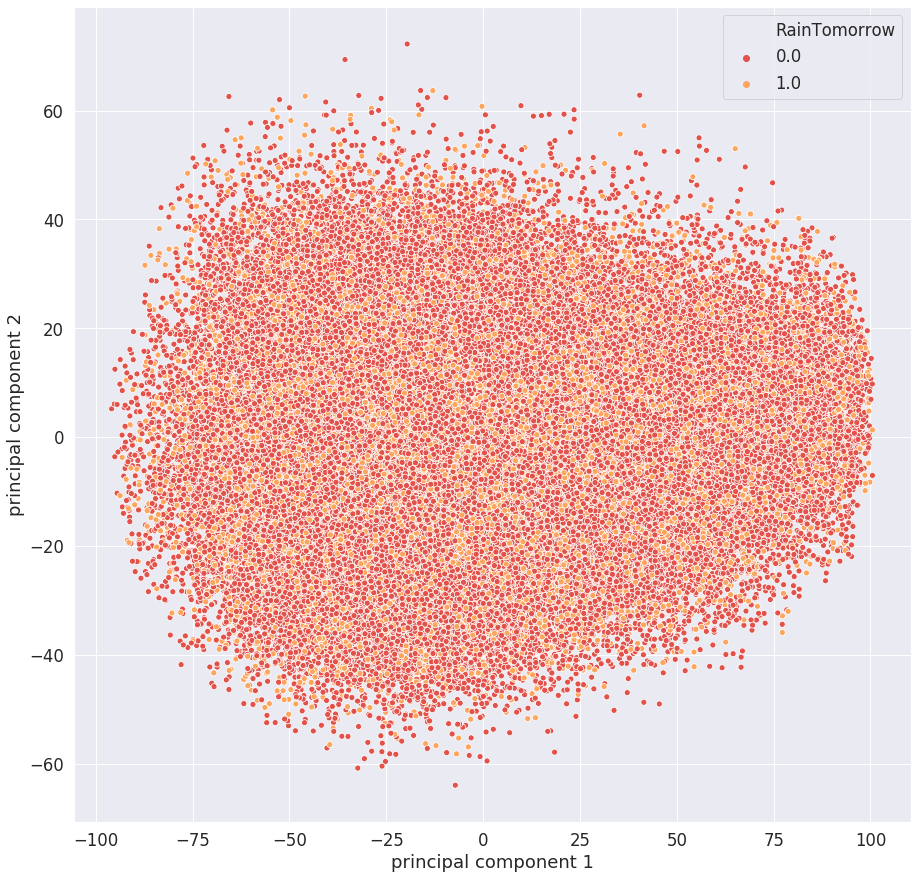

In [8]:
X = df.drop(['RainTomorrow', 'RainToday'], axis=1)

pca = PCA(n_components=2)
pca.fit(X)
principalComponents = pca.transform(X)
principalData = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

target = df['RainTomorrow'] 

fig, ax = plt.subplots(figsize=(15, 15))
sns.scatterplot(data=principalData, x='principal component 1', y='principal component 2',hue=target, ax=ax, legend='full')

<BarContainer object of 11 artists>

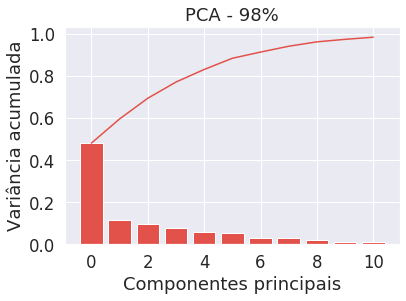

In [16]:
X = df.drop(['RainTomorrow', 'RainToday'], axis=1)

pca = PCA(n_components=0.98)
pca.fit(X)
X_pca = pca.transform(X)

#plot explained_variance
plt.title("PCA - 98%")
plt.ylabel('Variância acumulada')
plt.xlabel('Componentes principais')
plt.plot(np.cumsum(pca.explained_variance_ratio_))
y_pos = np.arange(len(pca.explained_variance_ratio_))
plt.bar(y_pos, pca.explained_variance_ratio_)

## Undersampling

In [32]:
# X = df.drop(['RainTomorrow', 'RainToday'], axis=1)
X = X_pca
y = df['RainTomorrow']

#Balancing classes with undersampling
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X, y)

# Split training data to enable model verification
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=26)

print("Shape")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print ("X_test:", X_test.shape)

Shape
X_train: (39529, 11)
y_train: (39529,)
X_test: (9883, 11)


# Modelos Lineares 

In [36]:
Cs = [0.001, 0.1, 1.0, 10.0]

models = [
#     {
#         'model': LogisticRegression(),
#         'name': 'LogisticRegression',
#         'parameters': [{
#             'penalty': ['l1','l2', 'elasticnet', 'none'],
#             'C': Cs,
#             'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
#         }]
#     },
    {
        'model': RandomForestClassifier(),
        'name': 'RandomForest',
        'parameters': [{
            'n_estimators': [10, 100, 200, 500, 1000, 2000, 3000],
            'max_depth': [None, 3, 5, 10, 20, 50],
            'max_features': ['auto', 'sqrt', 'log2']
        }]
    },
#     {
#         'model': DecisionTreeClassifier(),
#         'name': 'DecisionTree',
#         'parameters': [{
#             'max_depth': [1, 10, 20],
#             'min_samples_leaf': [3, 4, 5],
#             'min_samples_split': [8, 10, 12],
#         }]
#     },
#     {
#         'model': KNeighborsClassifier(),
#         'name': 'KNeighbors',
#         'parameters': [{
#             'n_neighbors': [1, 10, 20, 30],
#             'p': [1,2,3, 4, 5],
#         }]
#     }
]



In [37]:
for model in models:
    clf = GridSearchCV(model['model'], model['parameters'], cv=10, verbose=1, return_train_score=True, n_jobs=-1)
    clf.fit(X_train, y_train)

    results = pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score')
    results.to_csv('results_{0}_cv10_pca98_2.csv'.format(model['name']), index=False)

Fitting 10 folds for each of 126 candidates, totalling 1260 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   54.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 38.0min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 65.0min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 104.8min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed: 203.8min
[Parallel(n_jobs=-1)]: Done 1260 out of 1260 | elapsed: 221.1min finished


In [ ]:
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import recall_score
import warnings
warnings.filterwarnings('ignore')

models = [
#     LinearRegression(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()
]

names = [
#     'Linear Classifier',
    'Gaussian Naive Bayes',
    'Quadratic Discriminant Analysis',
]

for model, name in zip(models, names):
    scores = cross_validate(model, X_train, y_train, cv=10, scoring=['precision_macro','recall_macro','accuracy','f1_macro'])
    print("{}:\n\tPrecision: {}\n\tRecall: {}\n\tF1-Score: {}\n\tAccuracy: {}\n".format(name,np.mean(scores['test_precision_macro']),np.mean(scores['test_recall_macro']),np.mean(scores['test_f1_macro']), np.mean(scores['test_accuracy'])))
  
    y_pred = cross_val_predict(model, X_train, y_train, cv=10)
    confusion = confusion_matrix(y_resampled, y_pred)
    
    p = sns.heatmap(confusion, annot=True, fmt="d")
    plt.show()

# Modelos não lineares

## SVM

In [11]:
# gammas = ['auto', 'scale'] + [ 1.0, 10.0, 100.0, 1000.0]
gammas = [0.001,0.0001]
Cs = [1.0, 10.0]
# Cs = [1000.0]

parameters = [
    {
        'kernel': ['rbf'],
        'gamma': gammas,
        'C': Cs
    },
#     {
#         'kernel': ['linear'],
#         'C': Cs
#     },
#     {
#         'kernel': ['sigmoid'],
#         'gamma': [1, 0.5, 0.01],
#         'C': Cs
#     },
#     {
#         'kernel': ['poly'],
#         'gamma': ['scale'],
#         'degree': [2, 3, 4, 5],
#         'C': Cs
#     }
]

In [12]:
for param in parameters:
    print(param)
    clf = GridSearchCV(SVC(), param, cv=10, verbose=1, return_train_score=True, n_jobs=-1)
    clf.fit(X_resampled, y_resampled)

    results = pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score')
    results.to_csv('results_{0}_cv10_pca98_2.csv'.format(param['kernel'][0]), index=False)

{'gamma': [0.001, 0.0001], 'C': [1.0, 10.0], 'kernel': ['rbf']}
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 41.0min finished


In [16]:
clf = SVC(kernel='rbf', gamma='scale', C=1.0)
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [17]:
clf.score(X_test, y_test)

0.7794192046949306

### Melhor modelo: $\gamma = scale$ , $C = 1.0 $, $kernel: RBF$  

### Rede Neural

In [ ]:
from torch import nn, randn
import torch.nn.functional as F
from skorch import NeuralNetClassifier

class TorchModule(nn.Module):
    def __init__(self, num_units=10):
        super(TorchModule, self).__init__()

        self.activation = F.tanh
                
        self.hidden = nn.Linear(28, num_units)
        self.output = nn.Linear(num_units, 2)

    def forward(self, X, **kwargs):
        X = self.activation(self.hidden(X))
        X = F.softmax(self.output(X), dim=1)
        return X

net = NeuralNetClassifier(
    TorchModule,
    max_epochs=2,
    lr=0.1,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)

X = df.drop(['RainTomorrow', 'RainToday'], axis=1).values.astype(np.float32)
y = df['RainTomorrow'].values.astype(np.int64)

params = {
    'lr': [0.01, 0.02],
    'max_epochs': [10, 20],
    'module__num_units': [10, 20],
}
gs = GridSearchCV(net, params, refit=False, cv=3, scoring='accuracy')

gs.fit(X, y)
print(gs.best_score_, gs.best_params_)


In [ ]:
X_train = tensor(X_train).float().to('cuda').cpu()
y_train = tensor(y_train).long().to('cuda').cpu()

In [45]:
from torch import nn, randn, tanh, tensor
import torch.nn.functional as F
from skorch import NeuralNetClassifier

class TorchModule2(nn.Module):
    def __init__(self, num_units=10):
        super(TorchModule2, self).__init__()

        self.activation = tanh
                
#         self.hidden0 = nn.Linear(28, num_units)
        self.dropout = nn.Dropout(0.5)
        self.hidden1 = nn.Linear(11, num_units)
        self.output = nn.Linear(num_units, 2)

    def forward(self, X, **kwargs):
#         X = self.activation(self.hidden0(X))
        X = self.activation(self.hidden1(X))
        X = self.dropout(X)
        X = F.softmax(self.output(X), dim=1)
        return X

net = NeuralNetClassifier(
    TorchModule2,
    max_epochs=2,
    lr=0.1,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    device='cuda'
)



# X_train = df.drop(['RainTomorrow', 'RainToday'], axis=1).values.astype(np.float32)
# y = df['RainTomorrow'].values.astype(np.int64)

params = {
    'lr': [0.01, 0.02],
    'max_epochs': [50],
    'module__num_units': [10, 20, 50],
}

gs = GridSearchCV(net, params, refit=False, cv=10, scoring='accuracy')

gs.fit(X_train, y_train)
print(gs.best_score_, gs.best_params_)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6373       0.7236        0.5599  0.8027


/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5698       0.7461        0.5314  0.7503
      3        0.5531       0.7539        0.5178  0.9407
      4        0.5425       0.7605        0.5096  1.0502
      5        0.5379       0.7655        0.5057  0.7364
      6        0.5316       0.7611        0.5022  0.7911
      7        0.5300       0.7650        0.5003  0.7911
      8        0.5286       0.7634        0.4979  0.7669
      9        0.5257       0.7660        0.4950  0.7756
     10        0.5222       0.7670        0.4951  0.9048
     11        0.5232       0.7664        0.4948  0.7441
     12        0.5233       0.7677        0.4941  0.8150
     13        0.5214       0.7683        0.4936  0.9358
     14        0.5212       0.7684        0.4919  0.9213
     15        0.5189       0.7684        0.4914  0.9326
     16        0.5163       0.7680        0.4913  0.7322
     17        0.5182       0.7698        0.4915  0.8750
     18        0.5170       0.7687        0.4910  1.0288
     19        0.5180       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5769       0.7348        0.5462  0.9505
      3        0.5578       0.7476        0.5283  0.7713
      4        0.5444       0.7507        0.5163  0.9942
      5        0.5343       0.7545        0.5089  0.7632
      6        0.5304       0.7573        0.5070  1.0780
      7        0.5276       0.7600        0.5028  0.7884
      8        0.5271       0.7615        0.5029  0.7954
      9        0.5271       0.7615        0.5021  0.9177
     10        0.5257       0.7608        0.5016  1.0738
     11        0.5223       0.7603        0.5012  1.1328
     12        0.5194       0.7601        0.5010  1.0439
     13        0.5200       0.7605        0.4997  0.8483
     14        0.5196       0.7601        0.4997  0.9700
     15        0.5155       0.7624        0.4988  0.9313
     16        0.5146       0.7632        0.4983  1.0090
     17        0.5171       0.7641        0.4973  0.7534
     18        0.5142       0.7664        0.4977  0.7200
     19        0.5132       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5716       0.7366        0.5356  0.8313
      3        0.5508       0.7496        0.5196  0.9392
      4        0.5377       0.7545        0.5131  0.8453
      5        0.5362       0.7560        0.5090  1.0293
      6        0.5301       0.7598        0.5064  1.0163
      7        0.5273       0.7610        0.5032  0.8501
      8        0.5233       0.7624        0.5021  0.8158
      9        0.5263       0.7626        0.5021  0.7384
     10        0.5207       0.7653        0.5001  0.9816
     11        0.5232       0.7648        0.4988  0.8140
     12        0.5209       0.7619        0.4984  0.7326
     13        0.5197       0.7626        0.4995  0.7650
     14        0.5188       0.7625        0.4985  0.7766
     15        0.5185       0.7645        0.4968  0.7608
     16        0.5150       0.7653        0.4962  0.7870
     17        0.5165       0.7673        0.4948  0.8406
     18        0.5159       0.7674        0.4959  0.8171
     19        0.5133       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5656       0.7499        0.5284  0.4824
      3        0.5557       0.7513        0.5188  0.4662
      4        0.5442       0.7576        0.5124  0.4606
      5        0.5405       0.7617        0.5085  0.4704
      6        0.5339       0.7614        0.5051  0.4487
      7        0.5296       0.7652        0.5010  0.4587
      8        0.5251       0.7659        0.5000  0.4709
      9        0.5291       0.7671        0.4992  0.4647
     10        0.5265       0.7667        0.4987  0.4878
     11        0.5246       0.7667        0.4980  0.4669
     12        0.5238       0.7656        0.4974  0.4639
     13        0.5241       0.7646        0.4970  0.4616
     14        0.5212       0.7652        0.4980  0.4795
     15        0.5207       0.7666        0.4965  0.4592
     16        0.5188       0.7657        0.4969  0.4571
     17        0.5216       0.7678        0.4948  0.4425
     18        0.5208       0.7678        0.4969  0.4555
     19        0.5199       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5757       0.7497        0.5315  0.4844
      3        0.5548       0.7603        0.5151  0.4685
      4        0.5406       0.7653        0.5064  0.4594
      5        0.5325       0.7656        0.5032  0.4619
      6        0.5300       0.7645        0.5015  0.4782
      7        0.5264       0.7669        0.4991  0.4696
      8        0.5220       0.7695        0.4972  0.4678
      9        0.5207       0.7660        0.4969  0.4698
     10        0.5166       0.7684        0.4959  0.4702
     11        0.5202       0.7680        0.4965  0.4626
     12        0.5170       0.7676        0.4953  0.4585
     13        0.5160       0.7667        0.4948  0.4578
     14        0.5168       0.7687        0.4952  0.4608
     15        0.5145       0.7704        0.4945  0.4513
     16        0.5128       0.7695        0.4939  0.4721
     17        0.5140       0.7700        0.4935  0.4864
     18        0.5143       0.7662        0.4944  0.4599
     19        0.5130       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5737       0.7410        0.5376  0.5074
      3        0.5621       0.7482        0.5270  0.4564
      4        0.5526       0.7542        0.5191  0.4481
      5        0.5482       0.7570        0.5152  0.4548
      6        0.5417       0.7607        0.5109  0.4640
      7        0.5416       0.7589        0.5102  0.4647
      8        0.5357       0.7562        0.5065  0.4571
      9        0.5332       0.7577        0.5064  0.4800
     10        0.5317       0.7586        0.5046  0.4733
     11        0.5279       0.7611        0.5038  0.4811
     12        0.5271       0.7608        0.5030  0.4632
     13        0.5260       0.7629        0.5028  0.4657
     14        0.5234       0.7655        0.5008  0.4669
     15        0.5270       0.7635        0.5004  0.4783
     16        0.5241       0.7641        0.5013  0.4736
     17        0.5236       0.7664        0.4994  0.4771
     18        0.5225       0.7697        0.4987  0.4693
     19        0.5189       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5539       0.7553        0.5178  0.4751
      3        0.5420       0.7563        0.5105  0.4762
      4        0.5349       0.7600        0.5058  0.4694
      5        0.5307       0.7615        0.5013  0.4666
      6        0.5276       0.7636        0.4980  0.4875
      7        0.5207       0.7683        0.4951  0.4815
      8        0.5214       0.7676        0.4938  0.4707
      9        0.5204       0.7666        0.4933  0.4565
     10        0.5209       0.7670        0.4933  0.4818
     11        0.5209       0.7657        0.4938  0.4655
     12        0.5154       0.7669        0.4951  0.4748
     13        0.5147       0.7688        0.4921  0.4656
     14        0.5151       0.7674        0.4926  0.4585
     15        0.5141       0.7683        0.4938  0.4800
     16        0.5150       0.7695        0.4923  0.4707
     17        0.5137       0.7678        0.4919  0.4698
     18        0.5139       0.7725        0.4903  0.4692
     19        0.5119       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5468       0.7598        0.5114  0.4850
      3        0.5315       0.7648        0.5061  0.4745
      4        0.5314       0.7648        0.5041  0.4738
      5        0.5262       0.7649        0.5006  0.4780
      6        0.5253       0.7652        0.5009  0.4671
      7        0.5198       0.7639        0.4988  0.4815
      8        0.5228       0.7688        0.4977  0.4738
      9        0.5200       0.7674        0.4976  0.4725
     10        0.5195       0.7669        0.4964  0.5049
     11        0.5159       0.7693        0.4953  0.4765
     12        0.5178       0.7687        0.4946  0.4760
     13        0.5155       0.7693        0.4947  0.4768
     14        0.5164       0.7691        0.4949  0.4835
     15        0.5159       0.7671        0.4951  0.4854
     16        0.5163       0.7698        0.4947  0.4711
     17        0.5162       0.7695        0.4941  0.4614
     18        0.5154       0.7680        0.4933  0.4619
     19        0.5142       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5591       0.7619        0.5206  0.4951
      3        0.5465       0.7622        0.5136  0.4838
      4        0.5429       0.7653        0.5090  0.4643
      5        0.5377       0.7656        0.5063  0.4733
      6        0.5309       0.7685        0.5043  0.4824
      7        0.5306       0.7660        0.5032  0.4758
      8        0.5234       0.7662        0.5010  0.4656
      9        0.5235       0.7649        0.4993  0.4766
     10        0.5227       0.7660        0.4993  0.4717
     11        0.5200       0.7669        0.4982  0.4749
     12        0.5212       0.7691        0.4979  0.4780
     13        0.5168       0.7669        0.4964  0.4778
     14        0.5169       0.7694        0.4956  0.4552
     15        0.5151       0.7671        0.4957  0.4639
     16        0.5161       0.7694        0.4937  0.4725
     17        0.5151       0.7698        0.4971  0.4675
     18        0.5125       0.7698        0.4940  0.4734
     19        0.5140       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5688       0.7490        0.5323  0.4814
      3        0.5554       0.7576        0.5216  0.4817
      4        0.5460       0.7610        0.5158  0.4806
      5        0.5413       0.7614        0.5129  0.4579
      6        0.5375       0.7621        0.5108  0.4616
      7        0.5363       0.7601        0.5084  0.4711
      8        0.5318       0.7629        0.5075  0.4783
      9        0.5276       0.7631        0.5047  0.4691
     10        0.5267       0.7635        0.5044  0.4970
     11        0.5270       0.7625        0.5024  0.4701
     12        0.5236       0.7624        0.5027  0.4912
     13        0.5264       0.7632        0.5014  0.4834
     14        0.5228       0.7643        0.5000  0.4748
     15        0.5204       0.7650        0.4984  0.4645
     16        0.5208       0.7639        0.4989  0.4706
     17        0.5168       0.7646        0.4971  0.4869
     18        0.5194       0.7655        0.4968  0.4863
     19        0.5168       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5457       0.7565        0.5102  0.4989
      3        0.5291       0.7614        0.4995  0.4897
      4        0.5217       0.7625        0.4930  0.4916
      5        0.5153       0.7648        0.4903  0.5120
      6        0.5110       0.7648        0.4880  0.4801
      7        0.5099       0.7657        0.4872  0.4753
      8        0.5090       0.7671        0.4867  0.4759
      9        0.5057       0.7650        0.4860  0.4769
     10        0.5057       0.7681        0.4846  0.4768
     11        0.5057       0.7677        0.4845  0.4796
     12        0.5049       0.7688        0.4840  0.4672
     13        0.4999       0.7678        0.4839  0.4907
     14        0.5010       0.7698        0.4840  0.4823
     15        0.4975       0.7701        0.4831  0.4643
     16        0.5019       0.7718        0.4840  0.4931
     17        0.5005       0.7681        0.4841  0.4941
     18        0.4997       0.7714        0.4837  0.4734
     19        0.4967       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5481       0.7574        0.5131  0.4935
      3        0.5297       0.7601        0.5025  0.5346
      4        0.5245       0.7604        0.5001  0.4680
      5        0.5167       0.7608        0.4954  0.4886
      6        0.5159       0.7628        0.4942  0.4857
      7        0.5170       0.7629        0.4953  0.5016
      8        0.5084       0.7629        0.4924  0.4872
      9        0.5078       0.7612        0.4915  0.4899
     10        0.5095       0.7622        0.4915  0.4836
     11        0.5044       0.7619        0.4898  0.4872
     12        0.5061       0.7636        0.4898  0.4745
     13        0.5052       0.7638        0.4898  0.4841
     14        0.5036       0.7652        0.4889  0.4756
     15        0.5011       0.7643        0.4881  0.4793
     16        0.5021       0.7639        0.4888  0.4795
     17        0.5018       0.7653        0.4880  0.4595
     18        0.4994       0.7662        0.4878  0.4813
     19        0.4979       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5476       0.7553        0.5151  0.4883
      3        0.5352       0.7607        0.5072  0.4804
      4        0.5229       0.7655        0.4989  0.4773
      5        0.5167       0.7660        0.4948  0.4719
      6        0.5141       0.7674        0.4911  0.4662
      7        0.5104       0.7677        0.4899  0.4955
      8        0.5110       0.7680        0.4894  0.4824
      9        0.5092       0.7691        0.4895  0.4801
     10        0.5096       0.7708        0.4879  0.4819
     11        0.5070       0.7695        0.4879  0.4774
     12        0.5053       0.7709        0.4874  0.4688
     13        0.5065       0.7705        0.4875  0.4772
     14        0.5045       0.7707        0.4887  0.4789
     15        0.5056       0.7702        0.4882  0.4782
     16        0.5023       0.7705        0.4871  0.4961
     17        0.5042       0.7691        0.4873  0.4947
     18        0.5027       0.7674        0.4877  0.4873
     19        0.5031       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5706       0.7324        0.5424  0.4839
      3        0.5560       0.7423        0.5310  0.4746
      4        0.5467       0.7459        0.5225  0.4783
      5        0.5383       0.7504        0.5158  0.4820
      6        0.5305       0.7559        0.5109  0.4868
      7        0.5255       0.7587        0.5081  0.4747
      8        0.5230       0.7576        0.5051  0.4743
      9        0.5209       0.7594        0.5025  0.5097
     10        0.5154       0.7635        0.5002  0.4685
     11        0.5113       0.7632        0.4980  0.4593
     12        0.5121       0.7662        0.4966  0.4797
     13        0.5106       0.7671        0.4951  0.4757
     14        0.5098       0.7659        0.4943  0.4786
     15        0.5087       0.7667        0.4928  0.4800
     16        0.5077       0.7667        0.4929  0.4843
     17        0.5060       0.7678        0.4920  0.5024
     18        0.5041       0.7674        0.4905  0.4817
     19        0.5060       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5451       0.7607        0.5088  0.5207
      3        0.5332       0.7612        0.5038  0.4834
      4        0.5273       0.7618        0.5020  0.5471
      5        0.5203       0.7635        0.4989  0.5324
      6        0.5181       0.7657        0.4979  0.4795
      7        0.5175       0.7656        0.4963  0.5187
      8        0.5147       0.7697        0.4939  0.7572
      9        0.5121       0.7674        0.4930  0.6268
     10        0.5117       0.7669        0.4927  0.6371
     11        0.5086       0.7663        0.4920  0.6888
     12        0.5098       0.7676        0.4916  0.6087
     13        0.5072       0.7669        0.4915  0.5201
     14        0.5046       0.7670        0.4907  0.5220
     15        0.5056       0.7680        0.4917  0.5597
     16        0.5060       0.7678        0.4902  0.4977
     17        0.5032       0.7663        0.4910  0.5800
     18        0.5035       0.7677        0.4903  0.5623
     19        0.5012       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5383       0.7600        0.5100  0.5645
      3        0.5287       0.7617        0.5047  0.6911
      4        0.5210       0.7657        0.5002  0.6095
      5        0.5172       0.7680        0.4968  0.6176
      6        0.5150       0.7678        0.4950  0.6194
      7        0.5116       0.7690        0.4924  0.5103
      8        0.5111       0.7695        0.4924  0.6155
      9        0.5108       0.7701        0.4919  0.5538
     10        0.5072       0.7674        0.4913  0.5993
     11        0.5061       0.7677        0.4911  0.5836
     12        0.5082       0.7680        0.4909  0.4889
     13        0.5068       0.7687        0.4901  0.4843
     14        0.5045       0.7702        0.4899  0.5055
     15        0.5037       0.7681        0.4897  0.6009
     16        0.5044       0.7687        0.4894  0.6701
     17        0.5018       0.7698        0.4892  0.5937
     18        0.5035       0.7687        0.4884  0.4939
     19        0.5010       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5410       0.7601        0.5079  0.5629
      3        0.5295       0.7608        0.5047  0.8052
      4        0.5303       0.7611        0.5032  0.5230
      5        0.5250       0.7642        0.5017  0.5654
      6        0.5203       0.7648        0.4995  0.5815
      7        0.5181       0.7636        0.4979  0.5677
      8        0.5178       0.7673        0.4971  0.5437
      9        0.5166       0.7676        0.4967  0.5715
     10        0.5144       0.7662        0.4955  0.5268
     11        0.5123       0.7694        0.4951  0.5173
     12        0.5128       0.7704        0.4959  0.4971
     13        0.5108       0.7694        0.4953  0.4963
     14        0.5092       0.7681        0.4933  0.5231
     15        0.5095       0.7697        0.4932  0.5472
     16        0.5079       0.7690        0.4931  0.5020
     17        0.5059       0.7718        0.4934  0.5039
     18        0.5054       0.7705        0.4923  0.5058
     19        0.5045       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5402       0.7573        0.5098  0.4920
      3        0.5287       0.7615        0.5066  0.4910
      4        0.5234       0.7608        0.5030  0.5029
      5        0.5198       0.7636        0.4993  0.4828
      6        0.5148       0.7649        0.4973  0.4974
      7        0.5123       0.7673        0.4952  0.5018
      8        0.5108       0.7652        0.4928  0.4814
      9        0.5075       0.7666        0.4921  0.4850
     10        0.5090       0.7670        0.4910  0.4971
     11        0.5057       0.7655        0.4902  0.4743
     12        0.5063       0.7650        0.4894  0.4840
     13        0.5046       0.7667        0.4888  0.4762
     14        0.5035       0.7670        0.4891  0.4803
     15        0.5041       0.7646        0.4890  0.4770
     16        0.5006       0.7678        0.4888  0.4806
     17        0.5006       0.7663        0.4878  0.4919
     18        0.4995       0.7673        0.4881  0.4973
     19        0.5008       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5450       0.7544        0.5151  0.5200
      3        0.5317       0.7573        0.5067  0.4859
      4        0.5233       0.7598        0.5028  0.4937
      5        0.5177       0.7604        0.5010  0.4888
      6        0.5166       0.7617        0.4992  0.4807
      7        0.5106       0.7643        0.4963  0.4680
      8        0.5093       0.7638        0.4955  0.4955
      9        0.5095       0.7650        0.4947  0.4954
     10        0.5067       0.7641        0.4943  0.4843
     11        0.5050       0.7638        0.4933  0.4913
     12        0.5057       0.7660        0.4931  0.4866
     13        0.5025       0.7669        0.4931  0.4752
     14        0.5034       0.7664        0.4916  0.4809
     15        0.5021       0.7642        0.4928  0.4836
     16        0.5033       0.7642        0.4925  0.4784
     17        0.5009       0.7663        0.4927  0.4724
     18        0.5001       0.7660        0.4921  0.4876
     19        0.4987       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5584       0.7531        0.5245  0.4898
      3        0.5457       0.7583        0.5129  0.4991
      4        0.5326       0.7624        0.5044  0.4845
      5        0.5252       0.7660        0.4991  0.4789
      6        0.5197       0.7645        0.4952  0.4846
      7        0.5180       0.7631        0.4936  0.4710
      8        0.5121       0.7662        0.4921  0.4777
      9        0.5126       0.7649        0.4909  0.4829
     10        0.5100       0.7657        0.4909  0.4729
     11        0.5094       0.7662        0.4897  0.4735
     12        0.5103       0.7667        0.4896  0.4745
     13        0.5053       0.7695        0.4888  0.4820
     14        0.5064       0.7702        0.4886  0.4895
     15        0.5047       0.7714        0.4879  0.4907
     16        0.5054       0.7714        0.4884  0.4739
     17        0.5056       0.7708        0.4877  0.5083
     18        0.5048       0.7704        0.4875  0.4773
     19        0.5038       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5231       0.7604        0.4981  0.5128
      3        0.5139       0.7618        0.4925  0.4811
      4        0.5075       0.7657        0.4903  0.4777
      5        0.5049       0.7681        0.4877  0.4982
      6        0.5049       0.7688        0.4859  0.4790
      7        0.5001       0.7690        0.4850  0.4851
      8        0.4972       0.7669        0.4835  0.4867
      9        0.4979       0.7687        0.4839  0.4802
     10        0.4968       0.7681        0.4830  0.4866
     11        0.4975       0.7681        0.4832  0.4794
     12        0.4950       0.7666        0.4830  0.4807
     13        0.4953       0.7701        0.4825  0.4780
     14        0.4949       0.7715        0.4819  0.4736
     15        0.4942       0.7694        0.4814  0.4827
     16        0.4943       0.7704        0.4814  0.4656
     17        0.4892       0.7684        0.4811  0.4853
     18        0.4919       0.7680        0.4805  0.4997
     19        0.4910       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5205       0.7548        0.4994  0.5140
      3        0.5084       0.7594        0.4959  0.4789
      4        0.5074       0.7597        0.4952  0.4875
      5        0.5043       0.7619        0.4936  0.4797
      6        0.5010       0.7626        0.4930  0.4801
      7        0.4994       0.7615        0.4917  0.4739
      8        0.4964       0.7629        0.4909  0.4838
      9        0.4935       0.7615        0.4906  0.4836
     10        0.4916       0.7641        0.4897  0.4765
     11        0.4936       0.7631        0.4894  0.4848
     12        0.4921       0.7621        0.4902  0.4845
     13        0.4913       0.7625        0.4884  0.4810
     14        0.4887       0.7642        0.4884  0.4824
     15        0.4909       0.7646        0.4884  0.4760
     16        0.4898       0.7648        0.4883  0.4806
     17        0.4880       0.7664        0.4879  0.4926
     18        0.4891       0.7653        0.4877  0.4644
     19        0.4881       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5338       0.7572        0.5105  0.4941
      3        0.5230       0.7626        0.5032  0.4771
      4        0.5190       0.7662        0.4987  0.4946
      5        0.5120       0.7667        0.4961  0.4789
      6        0.5062       0.7670        0.4933  0.4843
      7        0.5037       0.7681        0.4927  0.4820
      8        0.5026       0.7694        0.4905  0.4801
      9        0.5011       0.7700        0.4896  0.4847
     10        0.4977       0.7701        0.4887  0.4838
     11        0.4984       0.7697        0.4882  0.4793
     12        0.4968       0.7685        0.4872  0.4827
     13        0.4956       0.7693        0.4875  0.4816
     14        0.4944       0.7695        0.4865  0.4844
     15        0.4928       0.7687        0.4863  0.4929
     16        0.4912       0.7685        0.4856  0.4811
     17        0.4915       0.7677        0.4863  0.4948
     18        0.4921       0.7657        0.4853  0.4901
     19        0.4899       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5285       0.7619        0.5042  0.4938
      3        0.5178       0.7649        0.4991  0.4746
      4        0.5124       0.7653        0.4957  0.4745
      5        0.5066       0.7687        0.4930  0.4710
      6        0.5052       0.7695        0.4921  0.4773
      7        0.5032       0.7687        0.4901  0.4800
      8        0.4994       0.7709        0.4889  0.4679
      9        0.4968       0.7714        0.4873  0.4758
     10        0.4943       0.7715        0.4870  0.4897
     11        0.4944       0.7721        0.4874  0.4772
     12        0.4920       0.7726        0.4857  0.4964
     13        0.4902       0.7716        0.4842  0.4879
     14        0.4917       0.7723        0.4844  0.4834
     15        0.4900       0.7711        0.4845  0.4896
     16        0.4903       0.7723        0.4846  0.5004
     17        0.4894       0.7726        0.4838  0.4812
     18        0.4899       0.7723        0.4843  0.4880
     19        0.4882       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5229       0.7612        0.4992  0.4874
      3        0.5125       0.7635        0.4964  0.4886
      4        0.5073       0.7678        0.4944  0.4904
      5        0.5051       0.7643        0.4943  0.4773
      6        0.5041       0.7653        0.4943  0.4719
      7        0.5028       0.7670        0.4927  0.4682
      8        0.5009       0.7638        0.4922  0.4932
      9        0.5004       0.7684        0.4921  0.5007
     10        0.4996       0.7681        0.4906  0.5064
     11        0.4990       0.7697        0.4905  0.4747
     12        0.4974       0.7704        0.4892  0.4953
     13        0.4962       0.7693        0.4888  0.4987
     14        0.4966       0.7698        0.4884  0.4835
     15        0.4980       0.7688        0.4873  0.4743
     16        0.4942       0.7725        0.4871  0.4926
     17        0.4944       0.7712        0.4868  0.4838
     18        0.4951       0.7721        0.4864  0.4818
     19        0.4935       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5279       0.7580        0.5035  0.4944
      3        0.5172       0.7604        0.4990  0.4793
      4        0.5116       0.7653        0.4953  0.4986
      5        0.5076       0.7664        0.4924  0.4956
      6        0.5042       0.7674        0.4898  0.4772
      7        0.5024       0.7678        0.4888  0.4935
      8        0.5004       0.7707        0.4871  0.4635
      9        0.5005       0.7707        0.4867  0.4767
     10        0.4966       0.7704        0.4855  0.4749
     11        0.4974       0.7701        0.4850  0.4833
     12        0.4955       0.7690        0.4865  0.4810
     13        0.4950       0.7700        0.4850  0.4833
     14        0.4928       0.7716        0.4847  0.4840
     15        0.4940       0.7715        0.4841  0.4784
     16        0.4896       0.7723        0.4830  0.5051
     17        0.4918       0.7705        0.4845  0.4840
     18        0.4886       0.7690        0.4843  0.4870
     19        0.4922       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5213       0.7596        0.5017  0.4910
      3        0.5149       0.7638        0.4973  0.4797
      4        0.5088       0.7662        0.4937  0.4959
      5        0.5060       0.7657        0.4932  0.4770
      6        0.5028       0.7653        0.4912  0.4843
      7        0.5010       0.7648        0.4906  0.4894
      8        0.4974       0.7650        0.4891  0.4809
      9        0.4946       0.7673        0.4874  0.4705
     10        0.4965       0.7676        0.4867  0.4774
     11        0.4935       0.7673        0.4863  0.4801
     12        0.4938       0.7680        0.4861  0.4916
     13        0.4917       0.7697        0.4853  0.4910
     14        0.4910       0.7694        0.4850  0.4821
     15        0.4917       0.7700        0.4843  0.4810
     16        0.4912       0.7719        0.4842  0.4829
     17        0.4893       0.7723        0.4839  0.4823
     18        0.4871       0.7726        0.4840  0.4753
     19        0.4882       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5274       0.7583        0.5058  0.4847
      3        0.5168       0.7611        0.5001  0.4903
      4        0.5103       0.7646        0.4967  0.4869
      5        0.5094       0.7648        0.4945  0.5792
      6        0.5036       0.7642        0.4927  0.6388
      7        0.5048       0.7655        0.4919  0.5553
      8        0.5008       0.7659        0.4900  0.5620
      9        0.4994       0.7656        0.4905  0.5485
     10        0.4963       0.7641        0.4901  0.5809
     11        0.4938       0.7663        0.4894  0.5084
     12        0.4978       0.7685        0.4886  0.4924
     13        0.4942       0.7685        0.4875  0.4929
     14        0.4934       0.7677        0.4870  0.5870
     15        0.4952       0.7695        0.4871  0.5681
     16        0.4924       0.7683        0.4866  0.5985
     17        0.4898       0.7694        0.4858  0.5420
     18        0.4898       0.7698        0.4858  0.5609
     19        0.4898       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5270       0.7591        0.5033  0.5077
      3        0.5154       0.7652        0.4971  0.4901
      4        0.5075       0.7652        0.4945  0.4845
      5        0.5068       0.7656        0.4931  0.4793
      6        0.5023       0.7664        0.4912  0.4903
      7        0.5028       0.7671        0.4907  0.4869
      8        0.4992       0.7680        0.4893  0.4906
      9        0.4965       0.7669        0.4893  0.4744
     10        0.4973       0.7676        0.4900  0.4770
     11        0.4971       0.7670        0.4896  0.4801
     12        0.4931       0.7680        0.4879  0.4843
     13        0.4936       0.7708        0.4867  0.4905
     14        0.4948       0.7656        0.4880  0.4935
     15        0.4948       0.7677        0.4892  0.4975
     16        0.4939       0.7701        0.4871  0.4938
     17        0.4932       0.7705        0.4872  0.4871
     18        0.4919       0.7671        0.4874  0.4949
     19        0.4911       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5284       0.7551        0.5058  0.4874
      3        0.5169       0.7624        0.5020  0.5021
      4        0.5145       0.7614        0.4993  0.4739
      5        0.5124       0.7611        0.4980  0.4999
      6        0.5062       0.7643        0.4954  0.4897
      7        0.5077       0.7648        0.4944  0.4800
      8        0.5029       0.7655        0.4935  0.4909
      9        0.5019       0.7650        0.4917  0.4825
     10        0.5023       0.7667        0.4910  0.4906
     11        0.5004       0.7677        0.4904  0.4815
     12        0.4972       0.7670        0.4893  0.4757
     13        0.4967       0.7646        0.4898  0.4991
     14        0.4971       0.7664        0.4881  0.4815
     15        0.4950       0.7674        0.4868  0.4854
     16        0.4935       0.7677        0.4868  0.4867
     17        0.4923       0.7711        0.4865  0.5152
     18        0.4913       0.7701        0.4863  0.4900
     19        0.4897       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5674       0.7560        0.5258  0.4960
      3        0.5462       0.7600        0.5120  0.5192
      4        0.5385       0.7657        0.5064  0.4889
      5        0.5336       0.7612        0.5022  0.4984
      6        0.5279       0.7645        0.5005  0.4789
      7        0.5284       0.7676        0.4994  0.4759
      8        0.5251       0.7659        0.4984  0.4780
      9        0.5250       0.7626        0.4989  0.4978
     10        0.5246       0.7646        0.4972  0.4785
     11        0.5239       0.7629        0.4963  0.4727
     12        0.5212       0.7691        0.4948  0.4966
     13        0.5202       0.7677        0.4978  0.4850
     14        0.5176       0.7655        0.4970  0.4820
     15        0.5201       0.7635        0.4932  0.4832
     16        0.5159       0.7649        0.4947  0.4812
     17        0.5169       0.7684        0.4927  0.4822
     18        0.5165       0.7684        0.4898  0.4780
     19        0.5154       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5535       0.7559        0.5224  0.5067
      3        0.5384       0.7558        0.5150  0.4843
      4        0.5279       0.7577        0.5077  0.4816
      5        0.5241       0.7618        0.5049  0.4899
      6        0.5196       0.7619        0.5033  0.4774
      7        0.5196       0.7636        0.5014  0.4829
      8        0.5150       0.7643        0.5001  0.4853
      9        0.5137       0.7625        0.4990  0.4846
     10        0.5136       0.7632        0.4988  0.4767
     11        0.5131       0.7629        0.4980  0.4875
     12        0.5125       0.7643        0.4978  0.4879
     13        0.5078       0.7656        0.4967  0.4800
     14        0.5113       0.7632        0.4976  0.4849
     15        0.5108       0.7655        0.4972  0.4738
     16        0.5092       0.7655        0.4979  0.4830
     17        0.5096       0.7660        0.4959  0.4840
     18        0.5092       0.7645        0.4968  0.4869
     19        0.5085       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5722       0.7548        0.5297  0.5033
      3        0.5534       0.7618        0.5155  0.4774
      4        0.5461       0.7625        0.5093  0.4894
      5        0.5375       0.7629        0.5039  0.4901
      6        0.5347       0.7667        0.5009  0.4907
      7        0.5276       0.7660        0.4963  0.4849
      8        0.5236       0.7650        0.4974  0.4868
      9        0.5220       0.7676        0.4958  0.4775
     10        0.5174       0.7705        0.4921  0.4883
     11        0.5198       0.7688        0.4935  0.5073
     12        0.5166       0.7695        0.4947  0.5374
     13        0.5143       0.7714        0.4941  0.7306
     14        0.5109       0.7688        0.4935  0.5084
     15        0.5107       0.7698        0.4922  0.4911
     16        0.5134       0.7709        0.4928  0.4803
     17        0.5123       0.7726        0.4916  0.4798
     18        0.5109       0.7719        0.4934  0.4924
     19        0.5105       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5341       0.7639        0.5039  0.4896
      3        0.5269       0.7680        0.4993  0.4792
      4        0.5231       0.7660        0.4968  0.4915
      5        0.5211       0.7684        0.4967  0.4817
      6        0.5164       0.7693        0.4947  0.4768
      7        0.5167       0.7674        0.4947  0.4614
      8        0.5141       0.7663        0.4930  0.4886
      9        0.5152       0.7662        0.4936  0.4674
     10        0.5128       0.7677        0.4937  0.4884
     11        0.5129       0.7695        0.4910  0.4829
     12        0.5140       0.7624        0.4980  0.4842
     13        0.5105       0.7646        0.4944  0.4818
     14        0.5135       0.7698        0.4926  0.4762
     15        0.5119       0.7677        0.4947  0.5007
     16        0.5074       0.7601        0.4970  0.4781
     17        0.5099       0.7645        0.4952  0.4779
     18        0.5108       0.7705        0.4925  0.4895
     19        0.5094       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5628       0.7480        0.5216  0.4861
      3        0.5414       0.7570        0.5105  0.5068
      4        0.5353       0.7619        0.5037  0.4787
      5        0.5284       0.7626        0.5014  0.4803
      6        0.5245       0.7656        0.4992  0.4822
      7        0.5204       0.7662        0.4969  0.4909
      8        0.5200       0.7677        0.4979  0.4963
      9        0.5180       0.7674        0.4963  0.4807
     10        0.5190       0.7687        0.4969  0.4772
     11        0.5169       0.7667        0.4958  0.4733
     12        0.5155       0.7680        0.4937  0.4747
     13        0.5158       0.7695        0.4935  0.4814
     14        0.5129       0.7695        0.4939  0.4845
     15        0.5146       0.7673        0.4938  0.4848
     16        0.5134       0.7671        0.4920  0.4794
     17        0.5113       0.7684        0.4929  0.4821
     18        0.5124       0.7707        0.4923  0.4905
     19        0.5099       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5440       0.7622        0.5090  0.4924
      3        0.5379       0.7666        0.5017  0.4717
      4        0.5316       0.7660        0.5031  0.4990
      5        0.5258       0.7636        0.5000  0.4932
      6        0.5229       0.7652        0.5004  0.4878
      7        0.5222       0.7691        0.4977  0.4824
      8        0.5233       0.7645        0.4994  0.4861
      9        0.5213       0.7697        0.4980  0.4887
     10        0.5161       0.7701        0.4958  0.4819
     11        0.5193       0.7680        0.4974  0.4832
     12        0.5176       0.7650        0.4990  0.4835
     13        0.5191       0.7691        0.4988  0.4725
     14        0.5159       0.7708        0.4957  0.4696
     15        0.5152       0.7715        0.4931  0.4742
     16        0.5146       0.7673        0.4950  0.4843
     17        0.5124       0.7671        0.4930  0.4696
     18        0.5122       0.7684        0.4925  0.4953
     19        0.5122       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5660       0.7549        0.5262  0.4952
      3        0.5523       0.7635        0.5128  0.4817
      4        0.5383       0.7657        0.5061  0.4668
      5        0.5319       0.7701        0.5033  0.4840
      6        0.5254       0.7677        0.5002  0.4867
      7        0.5228       0.7664        0.4998  0.4731
      8        0.5221       0.7678        0.4980  0.4847
      9        0.5210       0.7671        0.4973  0.4865
     10        0.5218       0.7685        0.4960  0.4798
     11        0.5180       0.7659        0.4958  0.4792
     12        0.5158       0.7691        0.4932  0.4798
     13        0.5151       0.7701        0.4933  0.4771
     14        0.5138       0.7707        0.4927  0.5031
     15        0.5167       0.7663        0.4953  0.4775
     16        0.5119       0.7721        0.4936  0.4807
     17        0.5130       0.7697        0.4934  0.4714
     18        0.5117       0.7701        0.4932  0.4836
     19        0.5095       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5547       0.7513        0.5181  0.5062
      3        0.5366       0.7603        0.5075  0.4917
      4        0.5300       0.7625        0.5014  0.4747
      5        0.5231       0.7632        0.5004  0.4879
      6        0.5184       0.7656        0.4977  0.4857
      7        0.5175       0.7646        0.4972  0.4908
      8        0.5175       0.7652        0.4972  0.4936
      9        0.5176       0.7662        0.4959  0.4896
     10        0.5158       0.7662        0.4976  0.4863
     11        0.5178       0.7648        0.4965  0.4773
     12        0.5147       0.7646        0.4969  0.4820
     13        0.5157       0.7632        0.4972  0.4853
     14        0.5158       0.7650        0.4958  0.5146
     15        0.5154       0.7656        0.4962  0.4789
     16        0.5116       0.7629        0.4966  0.4788
     17        0.5122       0.7680        0.4960  0.4963
     18        0.5161       0.7678        0.4968  0.4948
     19        0.5147       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5501       0.7621        0.5127  0.5005
      3        0.5400       0.7660        0.5047  0.4815
      4        0.5276       0.7652        0.4993  0.4791
      5        0.5274       0.7663        0.4995  0.4843
      6        0.5249       0.7666        0.4994  0.4865
      7        0.5193       0.7704        0.4948  0.4910
      8        0.5179       0.7691        0.4959  0.4798
      9        0.5117       0.7694        0.4949  0.4743
     10        0.5162       0.7642        0.4984  0.4830
     11        0.5119       0.7674        0.4947  0.4746
     12        0.5134       0.7677        0.4956  0.4701
     13        0.5088       0.7684        0.4952  0.4863
     14        0.5083       0.7693        0.4929  0.4877
     15        0.5062       0.7667        0.4959  0.4923
     16        0.5077       0.7721        0.4920  0.4841
     17        0.5061       0.7698        0.4907  0.4759
     18        0.5076       0.7702        0.4924  0.4979
     19        0.5068       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5535       0.7583        0.5202  0.5070
      3        0.5430       0.7642        0.5103  0.4724
      4        0.5327       0.7674        0.5042  0.4767
      5        0.5280       0.7655        0.5022  0.4915
      6        0.5240       0.7643        0.4999  0.4877
      7        0.5240       0.7625        0.4991  0.4849
      8        0.5231       0.7652        0.4963  0.4788
      9        0.5211       0.7639        0.4973  0.4790
     10        0.5180       0.7643        0.4974  0.4800
     11        0.5159       0.7632        0.4933  0.4754
     12        0.5160       0.7659        0.4939  0.4797
     13        0.5118       0.7625        0.4930  0.4919
     14        0.5155       0.7643        0.4956  0.4733
     15        0.5149       0.7639        0.4950  0.4704
     16        0.5125       0.7649        0.4928  0.4797
     17        0.5111       0.7650        0.4945  0.4790
     18        0.5121       0.7652        0.4936  0.4786
     19        0.5132       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5302       0.7652        0.4993  0.4959
      3        0.5211       0.7678        0.4920  0.4794
      4        0.5115       0.7653        0.4905  0.4738
      5        0.5111       0.7659        0.4897  0.4864
      6        0.5096       0.7701        0.4859  0.4708
      7        0.5085       0.7698        0.4855  0.4868
      8        0.5059       0.7687        0.4853  0.4782
      9        0.5060       0.7701        0.4848  0.4954
     10        0.5042       0.7695        0.4864  0.4755
     11        0.5017       0.7712        0.4840  0.4757
     12        0.4992       0.7697        0.4843  0.5040
     13        0.4997       0.7712        0.4838  0.4743
     14        0.5010       0.7714        0.4839  0.4841
     15        0.4950       0.7685        0.4824  0.4803
     16        0.4978       0.7712        0.4834  0.4624
     17        0.4981       0.7707        0.4838  0.4950
     18        0.4984       0.7735        0.4823  0.4780
     19        0.4980       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5297       0.7597        0.5078  0.4961
      3        0.5190       0.7598        0.5047  0.5022
      4        0.5153       0.7594        0.5009  0.4766
      5        0.5103       0.7617        0.4993  0.4855
      6        0.5044       0.7621        0.4967  0.4909
      7        0.5039       0.7663        0.4952  0.4933
      8        0.5012       0.7641        0.4947  0.4778
      9        0.5016       0.7660        0.4938  0.4837
     10        0.5016       0.7659        0.4927  0.4892
     11        0.4999       0.7666        0.4930  0.4872
     12        0.4995       0.7671        0.4907  0.4881
     13        0.4969       0.7685        0.4907  0.4947
     14        0.4975       0.7688        0.4914  0.4798
     15        0.4971       0.7688        0.4890  0.4855
     16        0.4973       0.7676        0.4899  0.4979
     17        0.4954       0.7681        0.4902  0.4807
     18        0.4979       0.7688        0.4891  0.5004
     19        0.4976       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5250       0.7626        0.5001  0.5008
      3        0.5173       0.7656        0.4969  0.4731
      4        0.5114       0.7638        0.4933  0.4830
      5        0.5092       0.7655        0.4926  0.4840
      6        0.5080       0.7653        0.4927  0.4816
      7        0.5058       0.7650        0.4911  0.4819
      8        0.5039       0.7676        0.4910  0.4847
      9        0.5024       0.7639        0.4908  0.4868
     10        0.5008       0.7662        0.4893  0.5002
     11        0.5025       0.7662        0.4884  0.4959
     12        0.4989       0.7678        0.4882  0.5012
     13        0.5017       0.7662        0.4896  0.4915
     14        0.4985       0.7701        0.4888  0.4688
     15        0.5009       0.7701        0.4876  0.4806
     16        0.4998       0.7677        0.4875  0.4745
     17        0.4980       0.7667        0.4879  0.4882
     18        0.4974       0.7643        0.4883  0.4777
     19        0.4964       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5394       0.7565        0.5088  0.5745
      3        0.5269       0.7635        0.5017  0.4819
      4        0.5190       0.7636        0.4982  0.4720
      5        0.5150       0.7664        0.4957  0.4788
      6        0.5114       0.7677        0.4934  0.4766
      7        0.5090       0.7693        0.4917  0.4865
      8        0.5048       0.7678        0.4906  0.4768
      9        0.5046       0.7695        0.4886  0.4973
     10        0.5014       0.7676        0.4886  0.4842
     11        0.5008       0.7695        0.4887  0.4803
     12        0.5022       0.7715        0.4895  0.4952
     13        0.5018       0.7704        0.4878  0.4793
     14        0.5024       0.7702        0.4870  0.4743
     15        0.5005       0.7685        0.4861  0.4741
     16        0.5003       0.7701        0.4861  0.4764
     17        0.5001       0.7680        0.4880  0.4804
     18        0.4985       0.7695        0.4860  0.4856
     19        0.4983       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5338       0.7534        0.5109  0.4940
      3        0.5230       0.7565        0.5043  0.4881
      4        0.5167       0.7617        0.4978  0.4847
      5        0.5113       0.7650        0.4951  0.4803
      6        0.5075       0.7667        0.4934  0.4990
      7        0.5095       0.7615        0.4935  0.5037
      8        0.5057       0.7681        0.4914  0.4729
      9        0.5048       0.7649        0.4898  0.4979
     10        0.5033       0.7680        0.4892  0.4782
     11        0.5008       0.7702        0.4896  0.4988
     12        0.5011       0.7693        0.4892  0.4872
     13        0.5016       0.7684        0.4884  0.4894
     14        0.4993       0.7693        0.4881  0.4763
     15        0.5002       0.7669        0.4882  0.4780
     16        0.5015       0.7697        0.4886  0.4734
     17        0.4986       0.7695        0.4890  0.4897
     18        0.4977       0.7667        0.4878  0.4988
     19        0.4980       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5360       0.7587        0.5088  0.5061
      3        0.5244       0.7649        0.5030  0.4803
      4        0.5165       0.7652        0.4998  0.4906
      5        0.5181       0.7624        0.4972  0.4742
      6        0.5151       0.7650        0.4960  0.4824
      7        0.5130       0.7669        0.4955  0.4821
      8        0.5105       0.7655        0.4941  0.4826
      9        0.5093       0.7691        0.4928  0.4783
     10        0.5081       0.7698        0.4937  0.5010
     11        0.5092       0.7677        0.4922  0.4782
     12        0.5073       0.7677        0.4918  0.4943
     13        0.5044       0.7694        0.4925  0.4878
     14        0.5030       0.7695        0.4910  0.4947
     15        0.5055       0.7691        0.4910  0.4935
     16        0.5023       0.7683        0.4907  0.4766
     17        0.5035       0.7687        0.4907  0.5095
     18        0.5022       0.7681        0.4911  0.4992
     19        0.5042       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5264       0.7610        0.5022  0.4917
      3        0.5164       0.7638        0.4965  0.4838
      4        0.5106       0.7643        0.4961  0.4783
      5        0.5095       0.7687        0.4925  0.4959
      6        0.5055       0.7664        0.4916  0.4968
      7        0.5053       0.7688        0.4916  0.4806
      8        0.5007       0.7691        0.4925  0.4795
      9        0.5031       0.7708        0.4900  0.4745
     10        0.5018       0.7663        0.4895  0.4954
     11        0.5026       0.7677        0.4900  0.5012
     12        0.5002       0.7707        0.4887  0.5043
     13        0.4975       0.7729        0.4884  0.4845
     14        0.4999       0.7747        0.4893  0.4860
     15        0.5007       0.7685        0.4907  0.4794
     16        0.4992       0.7708        0.4886  0.4885
     17        0.4974       0.7723        0.4883  0.4753
     18        0.4971       0.7704        0.4896  0.4799
     19        0.4952       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5279       0.7662        0.4978  0.4854
      3        0.5184       0.7705        0.4955  0.4730
      4        0.5155       0.7683        0.4927  0.5042
      5        0.5119       0.7677        0.4917  0.5068
      6        0.5115       0.7707        0.4920  0.4840
      7        0.5074       0.7694        0.4932  0.4785
      8        0.5101       0.7659        0.4923  0.5172
      9        0.5066       0.7695        0.4899  0.4939
     10        0.5040       0.7709        0.4895  0.4801
     11        0.5029       0.7688        0.4893  0.4738
     12        0.5034       0.7681        0.4891  0.4858
     13        0.5024       0.7705        0.4886  0.4724
     14        0.5027       0.7709        0.4890  0.4764
     15        0.5022       0.7718        0.4896  0.4764
     16        0.5008       0.7719        0.4887  0.4856
     17        0.5014       0.7712        0.4900  0.4906
     18        0.5003       0.7708        0.4887  0.4853
     19        0.4997       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5317       0.7596        0.5058  0.5086
      3        0.5221       0.7626        0.4995  0.4999
      4        0.5145       0.7626        0.4963  0.4960
      5        0.5087       0.7662        0.4944  0.4741
      6        0.5071       0.7635        0.4946  0.4713
      7        0.5080       0.7667        0.4930  0.4821
      8        0.5048       0.7667        0.4918  0.4974
      9        0.5031       0.7667        0.4903  0.4930
     10        0.5030       0.7673        0.4920  0.4897
     11        0.5047       0.7657        0.4905  0.4745
     12        0.5023       0.7671        0.4908  0.4800
     13        0.5011       0.7645        0.4891  0.4959
     14        0.5002       0.7676        0.4889  0.4739
     15        0.4999       0.7691        0.4893  0.4900
     16        0.4972       0.7671        0.4887  0.4926
     17        0.4986       0.7674        0.4890  0.4847
     18        0.4986       0.7673        0.4885  0.4984
     19        0.4967       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5384       0.7605        0.5078  0.5011
      3        0.5283       0.7643        0.5030  0.4846
      4        0.5187       0.7670        0.4991  0.4847
      5        0.5149       0.7652        0.4966  0.4799
      6        0.5097       0.7670        0.4958  0.4808
      7        0.5098       0.7695        0.4954  0.4861
      8        0.5074       0.7712        0.4953  0.4759
      9        0.5063       0.7729        0.4947  0.4911
     10        0.5063       0.7700        0.4942  0.4843
     11        0.5061       0.7726        0.4929  0.4776
     12        0.5035       0.7694        0.4925  0.4849
     13        0.5026       0.7711        0.4917  0.4796
     14        0.5044       0.7708        0.4898  0.5063
     15        0.5029       0.7711        0.4902  0.4671
     16        0.5047       0.7711        0.4890  0.4837
     17        0.5033       0.7708        0.4898  0.4824
     18        0.4997       0.7685        0.4888  0.4998
     19        0.4993       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5193       0.7625        0.5013  0.4940
      3        0.5094       0.7660        0.4968  0.4746
      4        0.5057       0.7653        0.4929  0.5068
      5        0.5016       0.7664        0.4897  0.4884
      6        0.5006       0.7688        0.4885  0.4800
      7        0.4985       0.7685        0.4866  0.4879
      8        0.4963       0.7702        0.4860  0.4930
      9        0.4926       0.7683        0.4843  0.5032
     10        0.4937       0.7670        0.4844  0.4769
     11        0.4917       0.7649        0.4830  0.4853
     12        0.4908       0.7678        0.4820  0.4785
     13        0.4896       0.7695        0.4809  0.4827
     14        0.4907       0.7677        0.4824  0.5016
     15        0.4879       0.7673        0.4827  0.4898
     16        0.4879       0.7685        0.4820  0.5020
     17        0.4872       0.7690        0.4811  0.4908
     18        0.4867       0.7693        0.4808  0.5000
     19        0.4881       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5172       0.7663        0.4969  0.5164
      3        0.5074       0.7656        0.4936  0.4897
      4        0.5050       0.7642        0.4916  0.4851
      5        0.5005       0.7655        0.4904  0.4707
      6        0.4991       0.7674        0.4907  0.4814
      7        0.4957       0.7676        0.4882  0.5261
      8        0.4934       0.7671        0.4874  0.4906
      9        0.4931       0.7684        0.4874  0.4866
     10        0.4918       0.7671        0.4879  0.4871
     11        0.4932       0.7688        0.4868  0.5202
     12        0.4913       0.7677        0.4868  0.4862
     13        0.4907       0.7684        0.4871  0.4910
     14        0.4898       0.7685        0.4866  0.4719
     15        0.4899       0.7683        0.4861  0.4768
     16        0.4880       0.7669        0.4867  0.4899
     17        0.4864       0.7662        0.4880  0.4994
     18        0.4860       0.7666        0.4862  0.4800
     19        0.4865       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5198       0.7598        0.5006  0.4869
      3        0.5097       0.7625        0.4970  0.4859
      4        0.5080       0.7678        0.4942  0.5070
      5        0.5021       0.7694        0.4904  0.4861
      6        0.5009       0.7670        0.4889  0.4908
      7        0.4970       0.7709        0.4892  0.4847
      8        0.4969       0.7695        0.4885  0.5114
      9        0.4944       0.7714        0.4862  0.4812
     10        0.4930       0.7723        0.4861  0.4912
     11        0.4916       0.7697        0.4856  0.4950
     12        0.4941       0.7698        0.4865  0.4922
     13        0.4911       0.7704        0.4845  0.4911
     14        0.4873       0.7701        0.4834  0.4711
     15        0.4902       0.7723        0.4840  0.4967
     16        0.4881       0.7693        0.4831  0.4811
     17        0.4894       0.7702        0.4834  0.4870
     18        0.4888       0.7712        0.4832  0.4883
     19        0.4886       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5090       0.7643        0.4936  0.5011
      3        0.5046       0.7643        0.4917  0.4873
      4        0.5018       0.7660        0.4906  0.4971
      5        0.4989       0.7664        0.4900  0.4854
      6        0.4960       0.7693        0.4888  0.4897
      7        0.4955       0.7714        0.4873  0.4879
      8        0.4930       0.7712        0.4875  0.4982
      9        0.4924       0.7728        0.4859  0.4707
     10        0.4904       0.7693        0.4889  0.4735
     11        0.4880       0.7708        0.4865  0.4773
     12        0.4878       0.7730        0.4850  0.4761
     13        0.4877       0.7722        0.4858  0.4740
     14        0.4881       0.7722        0.4836  0.4924
     15        0.4871       0.7705        0.4854  0.4907
     16        0.4856       0.7690        0.4851  0.5069
     17        0.4871       0.7716        0.4843  0.4812
     18        0.4852       0.7712        0.4865  0.4695
     19        0.4848       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5143       0.7639        0.4957  0.5030
      3        0.5075       0.7655        0.4923  0.4770
      4        0.5032       0.7670        0.4910  0.4797
      5        0.5007       0.7688        0.4902  0.4927
      6        0.4972       0.7678        0.4883  0.4920
      7        0.4973       0.7701        0.4873  0.4883
      8        0.4987       0.7683        0.4878  0.4969
      9        0.4950       0.7681        0.4868  0.4758
     10        0.4922       0.7641        0.4866  0.4775
     11        0.4911       0.7663        0.4862  0.4818
     12        0.4900       0.7684        0.4853  0.4759
     13        0.4914       0.7700        0.4845  0.4682
     14        0.4909       0.7688        0.4848  0.4847
     15        0.4895       0.7685        0.4851  0.4943
     16        0.4900       0.7666        0.4850  0.4920
     17        0.4902       0.7674        0.4858  0.4842
     18        0.4878       0.7693        0.4856  0.4797
     19        0.4860       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5175       0.7611        0.4999  0.5075
      3        0.5104       0.7643        0.4972  0.4820
      4        0.5043       0.7663        0.4931  0.4749
      5        0.5021       0.7659        0.4904  0.4739
      6        0.5011       0.7708        0.4894  0.4827
      7        0.4975       0.7707        0.4876  0.4886
      8        0.4966       0.7697        0.4868  0.4843
      9        0.4933       0.7715        0.4868  0.5375
     10        0.4939       0.7725        0.4854  0.5033
     11        0.4921       0.7723        0.4853  0.4812
     12        0.4924       0.7707        0.4848  0.5099
     13        0.4912       0.7698        0.4855  0.5029
     14        0.4920       0.7701        0.4845  0.4940
     15        0.4886       0.7708        0.4838  0.4843
     16        0.4888       0.7704        0.4840  0.4895
     17        0.4901       0.7685        0.4853  0.4806
     18        0.4891       0.7715        0.4842  0.4869
     19        0.4899       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5153       0.7653        0.4978  0.4949
      3        0.5074       0.7649        0.4951  0.5984
      4        0.5011       0.7659        0.4930  0.5123
      5        0.4991       0.7655        0.4908  0.4885
      6        0.4973       0.7681        0.4896  0.4852
      7        0.4976       0.7714        0.4906  0.4698
      8        0.4947       0.7680        0.4871  0.4691
      9        0.4913       0.7722        0.4865  0.4748
     10        0.4913       0.7711        0.4851  0.4866
     11        0.4905       0.7694        0.4862  0.4782
     12        0.4889       0.7693        0.4844  0.4867
     13        0.4881       0.7722        0.4846  0.4813
     14        0.4882       0.7694        0.4844  0.4795
     15        0.4858       0.7691        0.4844  0.4892
     16        0.4868       0.7733        0.4844  0.4956
     17        0.4873       0.7714        0.4841  0.4841
     18        0.4848       0.7737        0.4834  0.4692
     19        0.4859       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5097       0.7646        0.4919  0.4781
      3        0.5020       0.7652        0.4891  0.4909
      4        0.4986       0.7657        0.4879  0.6341
      5        0.4970       0.7676        0.4863  0.5041
      6        0.4948       0.7676        0.4855  0.4830
      7        0.4942       0.7695        0.4852  0.4790
      8        0.4926       0.7687        0.4856  0.4908
      9        0.4917       0.7678        0.4853  0.4770
     10        0.4892       0.7688        0.4844  0.4830
     11        0.4898       0.7688        0.4841  0.4848
     12        0.4876       0.7702        0.4838  0.4930
     13        0.4868       0.7700        0.4845  0.4923
     14        0.4893       0.7693        0.4840  0.4825
     15        0.4881       0.7677        0.4852  0.4893
     16        0.4890       0.7680        0.4858  0.4897
     17        0.4883       0.7688        0.4845  0.4962
     18        0.4850       0.7683        0.4839  0.4732
     19        0.4853       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5182       0.7671        0.4955  0.4845
      3        0.5091       0.7688        0.4922  0.4776
      4        0.5022       0.7697        0.4894  0.4895
      5        0.5009       0.7687        0.4908  0.4851
      6        0.4950       0.7681        0.4893  0.4815
      7        0.4943       0.7705        0.4890  0.4825
      8        0.4935       0.7718        0.4880  0.4727
      9        0.4926       0.7721        0.4873  0.4853
     10        0.4947       0.7725        0.4869  0.4962
     11        0.4906       0.7700        0.4862  0.4790
     12        0.4916       0.7707        0.4860  0.5066
     13        0.4890       0.7711        0.4865  0.4954
     14        0.4900       0.7715        0.4851  0.5111
     15        0.4908       0.7683        0.4872  0.4915
     16        0.4877       0.7702        0.4867  0.4919
     17        0.4894       0.7716        0.4866  0.4899
     18        0.4875       0.7693        0.4859  0.4873
     19        0.4860       0.7

/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/victorgarritano/.pyenv/versions/3.7.4/envs/py_37/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


      2        0.5150       0.7652        0.4979  0.4893
      3        0.5094       0.7690        0.4946  0.4805
      4        0.5027       0.7698        0.4914  0.4910
      5        0.5026       0.7685        0.4906  0.4842
      6        0.5000       0.7697        0.4890  0.4789
      7        0.4976       0.7701        0.4880  0.4845
      8        0.4948       0.7708        0.4887  0.4980
      9        0.4959       0.7714        0.4858  0.4868
     10        0.4953       0.7707        0.4863  0.4747
     11        0.4930       0.7712        0.4856  0.5622
     12        0.4905       0.7702        0.4858  0.4869
     13        0.4910       0.7688        0.4853  0.4913
     14        0.4896       0.7707        0.4839  0.4856
     15        0.4914       0.7704        0.4853  0.4888
     16        0.4888       0.7701        0.4850  0.4917
     17        0.4894       0.7719        0.4836  0.4840
     18        0.4874       0.7709        0.4859  0.4909
     19        0.4870       0.7